<a href="https://colab.research.google.com/github/Sriya777/Speech-Processing/blob/main/SpeechProcessing_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sriya Nistala

BL.EN.U4AIE23034

Lab 3

In [ ]:
!pip install torch torchaudio librosa transformers matplotlib


1.Load and preprocess the recorded speech signal.

In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

audio_path = "/content/drive/MyDrive/Objective_1.wav"  # change filename

# Use librosa to load audio, as torchaudio encountered an ImportError with TorchCodec
waveform_np, sr = librosa.load(audio_path, sr=None, mono=True)
waveform = torch.from_numpy(waveform_np)

# Resample to 16 kHz using librosa if necessary
if sr != 16000:
    waveform_np_resampled = librosa.resample(y=waveform.numpy(), orig_sr=sr, target_sr=16000)
    waveform = torch.from_numpy(waveform_np_resampled)
    sr = 16000

# waveform is already 1D from librosa.load(mono=True) and torch.from_numpy()
# No need for waveform.squeeze()

duration = len(waveform) / sr

print("Sampling rate:", sr)
print("Duration (s):", round(duration, 2))

Sampling rate: 16000
Duration (s): 7.06


2.Automatically segment the speech into phoneme-level units (similar to previous lab).

In [ ]:
# Load Wav2Vec2 model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
# Run speech recognition
inputs = processor(
    waveform.numpy(),
    sampling_rate=sr,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_ids = torch.argmax(logits, dim=-1)[0]
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids)

print("CTC Tokens:")
print(tokens[:60])

CTC Tokens:
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'S', 'H', 'H', 'H', '<pad>', '<pad>', '<pad>', 'E', 'E', '<pad>', '|', '|', '|', '|', '|', '<pad>', '<pad>', '<pad>', '<pad>', 'J', '<pad>', '<pad>']


In [ ]:
audio_path = "/content/drive/MyDrive/LJ050-0277.wav"  # change filename

# Load audio using librosa instead of torchaudio
waveform_np, sr = librosa.load(audio_path, sr=None, mono=True)
waveform = torch.from_numpy(waveform_np)

# Resample to 16kHz using librosa
if sr != 16000:
    waveform_np_resampled = librosa.resample(y=waveform.numpy(), orig_sr=sr, target_sr=16000)
    waveform = torch.from_numpy(waveform_np_resampled)
    sr = 16000

# waveform is already 1D from librosa.load(mono=True) and torch.from_numpy()
# Removed waveform.squeeze() as it's likely already 1D
print("Sampling Rate:", sr)

Sampling Rate: 16000


3.Plot the time-domain waveform corresponding to each extracted phoneme.

In [ ]:
num_frames = logits.shape[1]
time_per_token = duration / num_frames

print("Estimated Time per Token:", round(time_per_token, 4), "seconds")


Estimated Time per Token: 0.02 seconds


In [ ]:
num_frames = logits.shape[1]
time_per_token = duration / num_frames

collapsed_tokens = []
collapsed_times = []

prev = None
for i, tok in enumerate(tokens):
    if tok != prev and tok != processor.tokenizer.pad_token:
        collapsed_tokens.append(tok)
        collapsed_times.append(i * time_per_token)
    prev = tok

print("\nCollapsed Tokens:")
print(collapsed_tokens)
print("Time per token:", round(time_per_token, 4), "s")




Collapsed Tokens:
['S', 'H', 'E', '|', 'J', 'U', 'D', 'G', 'E', 'D', '|', 'T', 'H', 'E', '|', 'B', 'L', 'U', 'E', '|', 'P', 'E', 'N', '|', 'P', 'U', 'T', '|', 'I', 'T', '|', 'O', 'N', '|', 'T', 'H', 'E', '|', 'T', 'A', 'B', 'L', 'E', '|', 'A', 'N', 'D', '|', 'Q', 'U', 'I', 'E', 'T', 'L', 'Y', '|', 'W', 'H', 'I', 'S', 'P', 'E', 'R', 'E', 'D', '|', 'Y', 'E', 'S', '|']
Time per token: 0.02 s


4.
For every phoneme segment:
✓
Identify its phoneme category (vowel, plosive, fricative, affricate, semivowel, diphthong, or whisper segment).
✓
Label the phoneme accordingly.

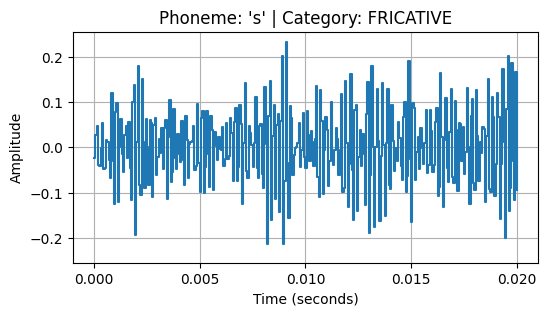

Phoneme: 's' → Category: FRICATIVE


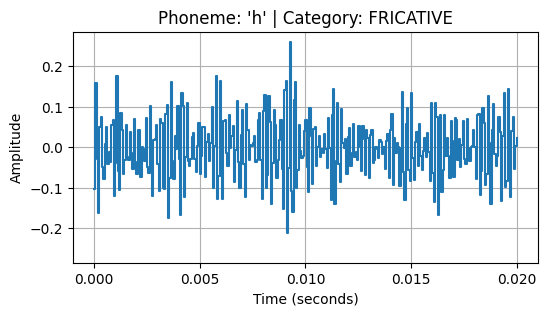

Phoneme: 'h' → Category: FRICATIVE


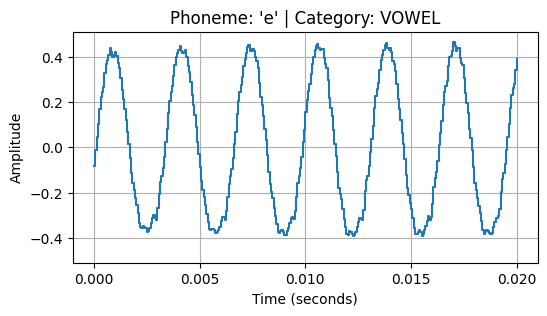

Phoneme: 'e' → Category: VOWEL


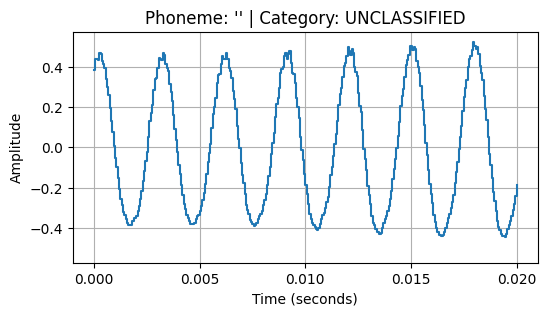

Phoneme: '' → Category: UNCLASSIFIED


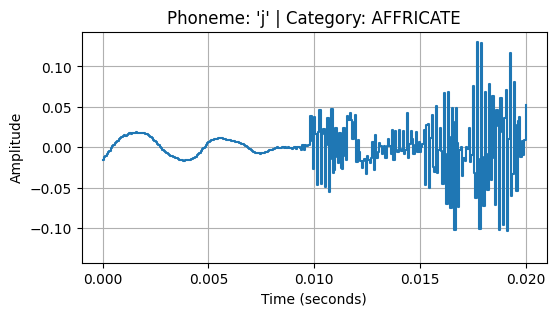

Phoneme: 'j' → Category: AFFRICATE


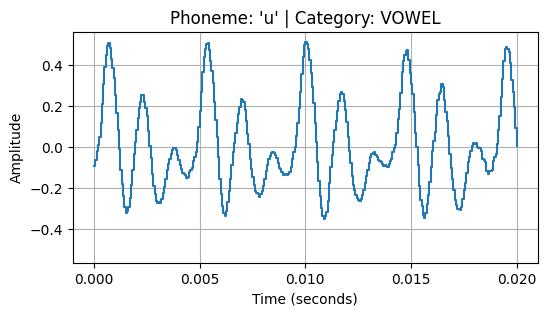

Phoneme: 'u' → Category: VOWEL


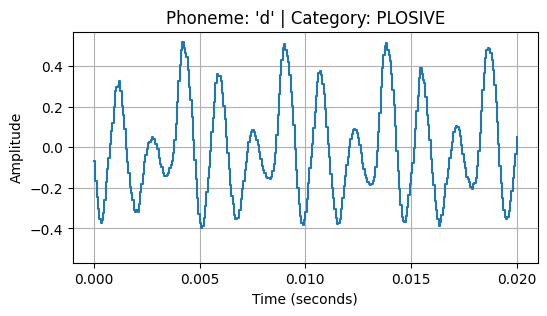

Phoneme: 'd' → Category: PLOSIVE


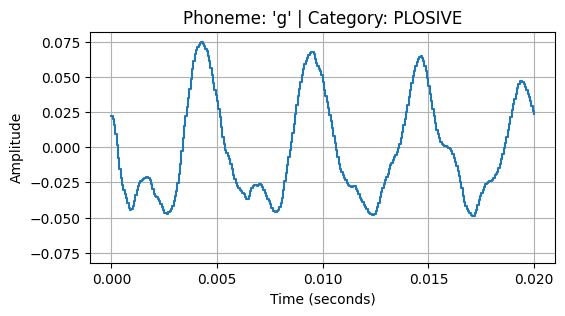

Phoneme: 'g' → Category: PLOSIVE


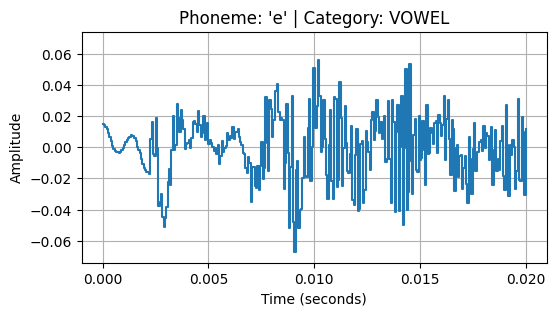

Phoneme: 'e' → Category: VOWEL


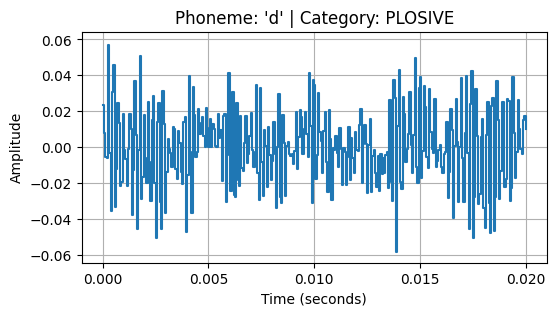

Phoneme: 'd' → Category: PLOSIVE


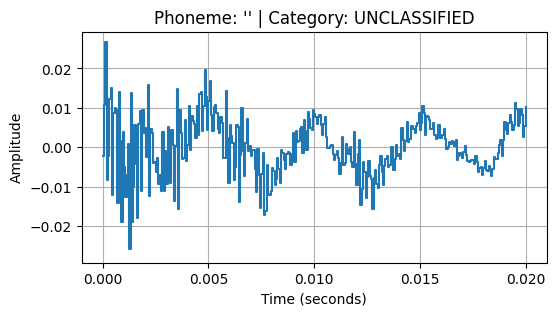

Phoneme: '' → Category: UNCLASSIFIED


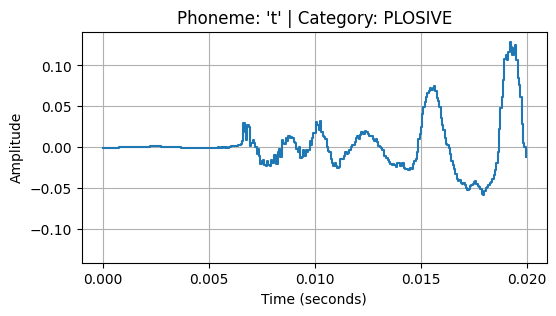

Phoneme: 't' → Category: PLOSIVE


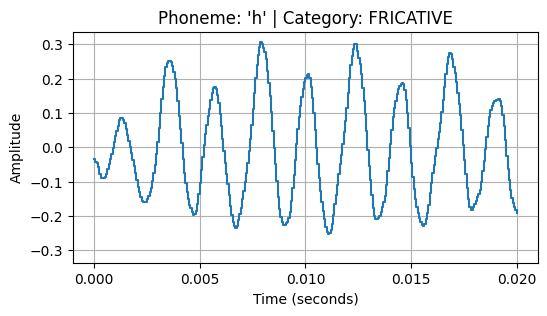

Phoneme: 'h' → Category: FRICATIVE


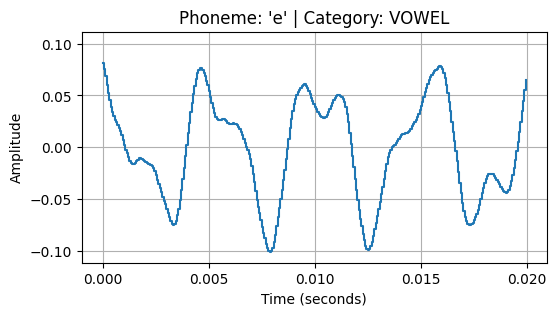

Phoneme: 'e' → Category: VOWEL


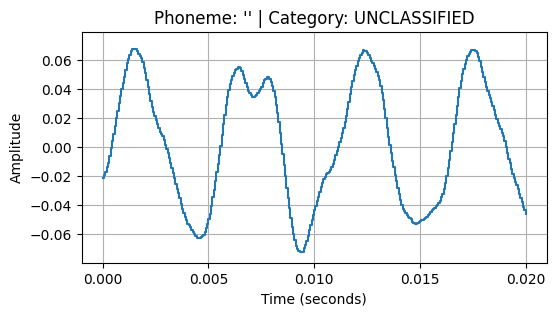

Phoneme: '' → Category: UNCLASSIFIED


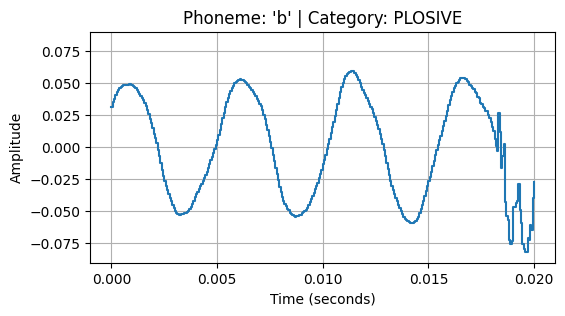

Phoneme: 'b' → Category: PLOSIVE


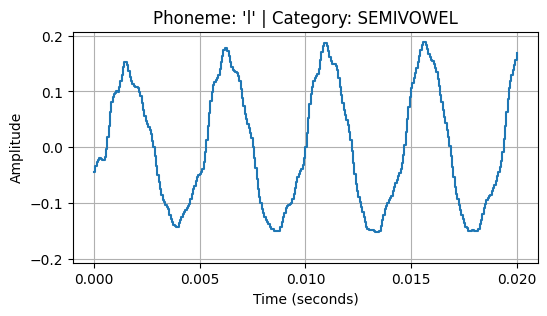

Phoneme: 'l' → Category: SEMIVOWEL


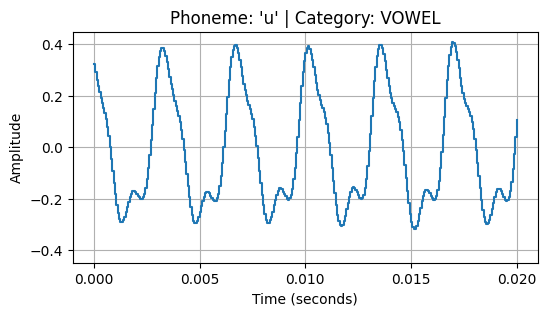

Phoneme: 'u' → Category: VOWEL


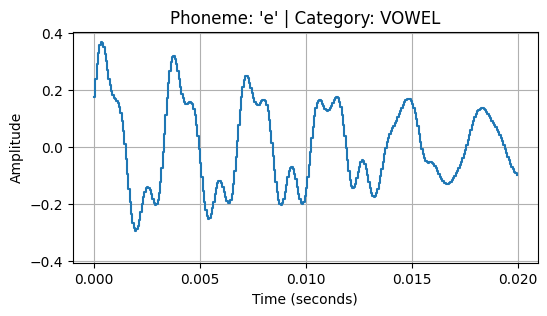

Phoneme: 'e' → Category: VOWEL


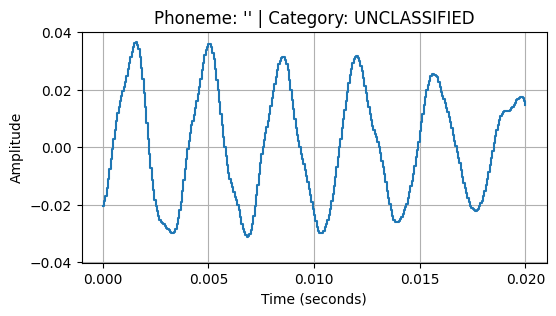

Phoneme: '' → Category: UNCLASSIFIED


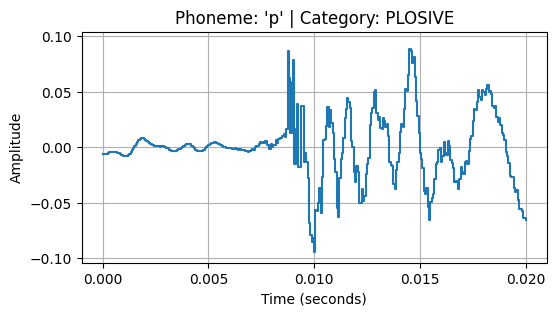

Phoneme: 'p' → Category: PLOSIVE


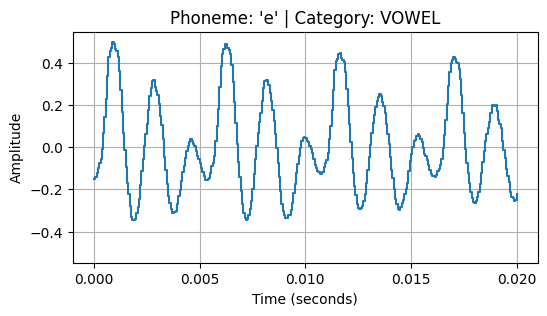

Phoneme: 'e' → Category: VOWEL


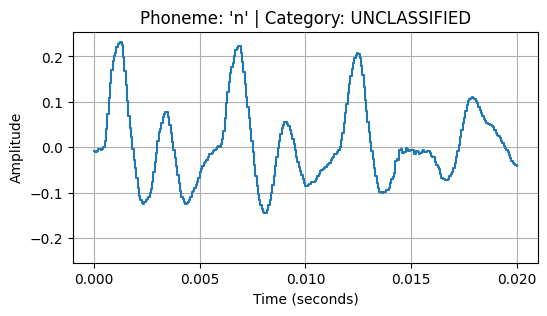

Phoneme: 'n' → Category: UNCLASSIFIED


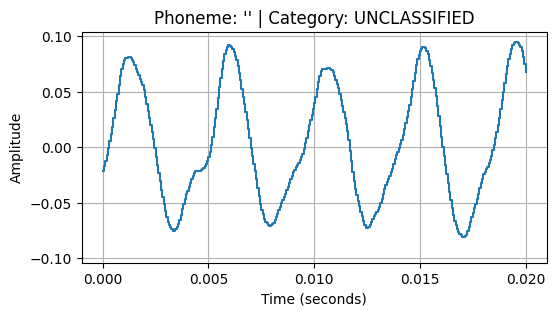

Phoneme: '' → Category: UNCLASSIFIED


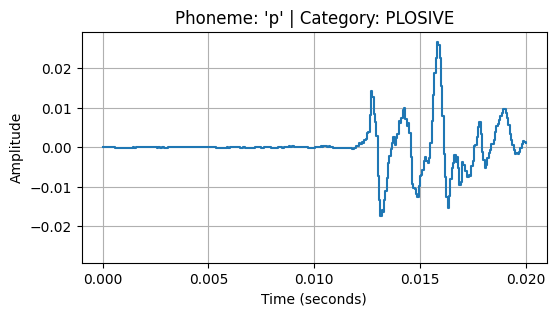

Phoneme: 'p' → Category: PLOSIVE


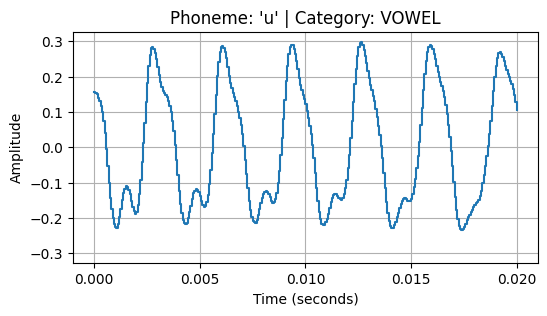

Phoneme: 'u' → Category: VOWEL


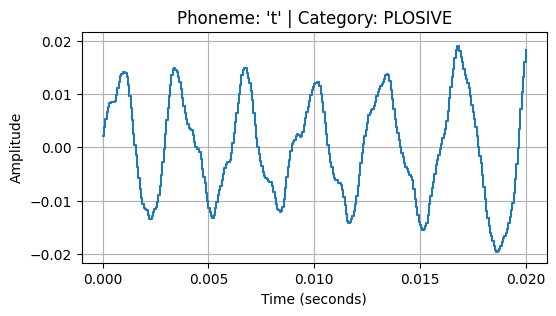

Phoneme: 't' → Category: PLOSIVE


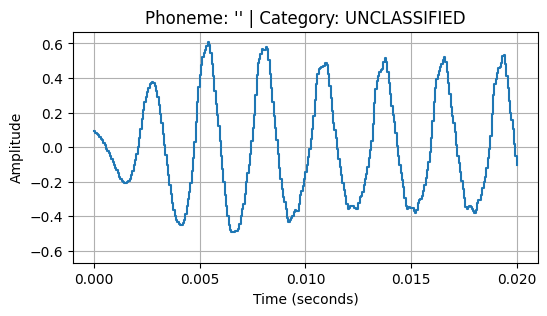

Phoneme: '' → Category: UNCLASSIFIED


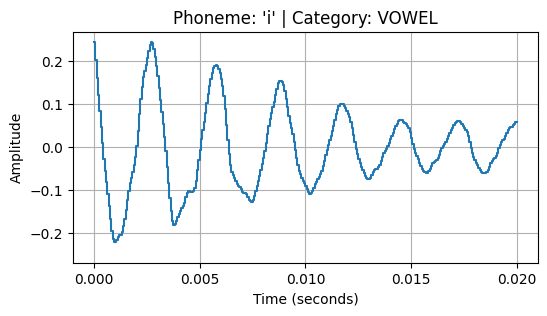

Phoneme: 'i' → Category: VOWEL


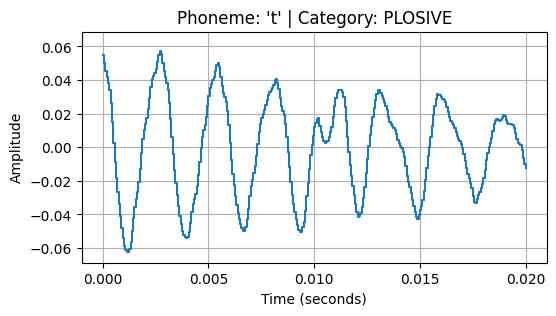

Phoneme: 't' → Category: PLOSIVE


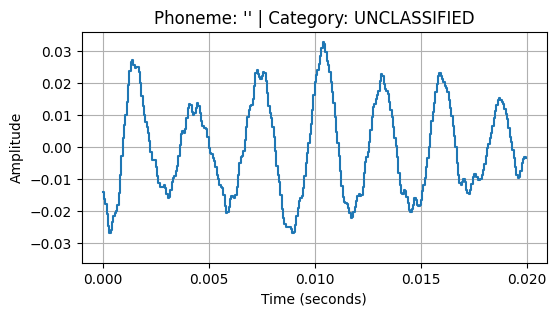

Phoneme: '' → Category: UNCLASSIFIED


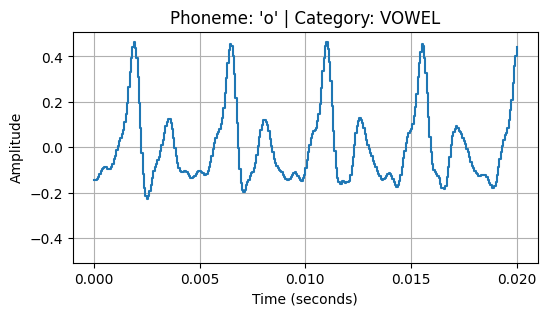

Phoneme: 'o' → Category: VOWEL


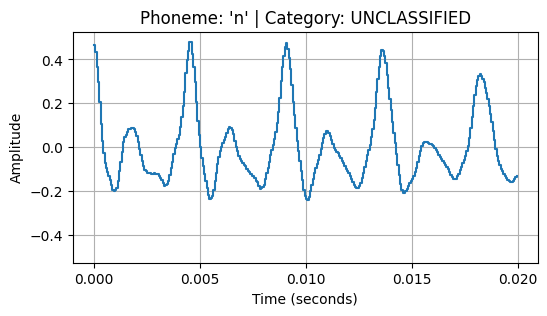

Phoneme: 'n' → Category: UNCLASSIFIED


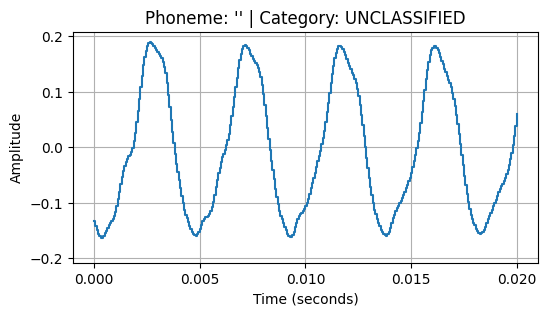

Phoneme: '' → Category: UNCLASSIFIED


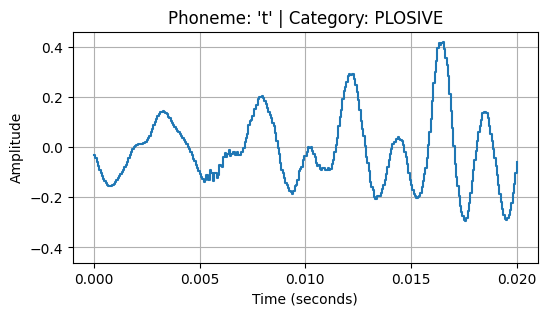

Phoneme: 't' → Category: PLOSIVE


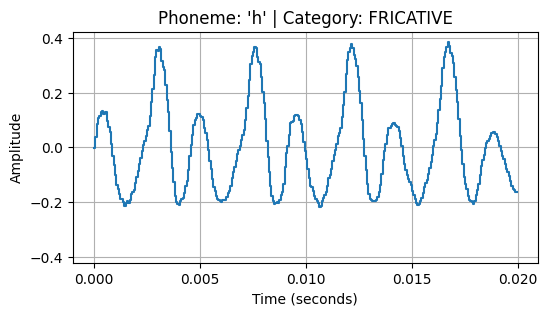

Phoneme: 'h' → Category: FRICATIVE


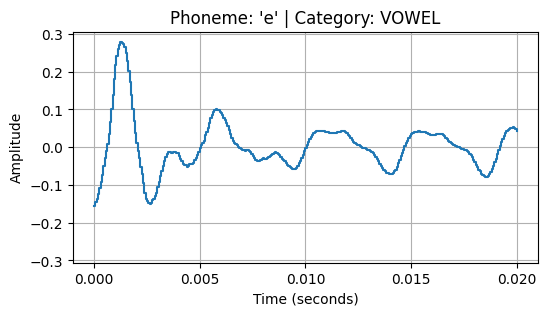

Phoneme: 'e' → Category: VOWEL


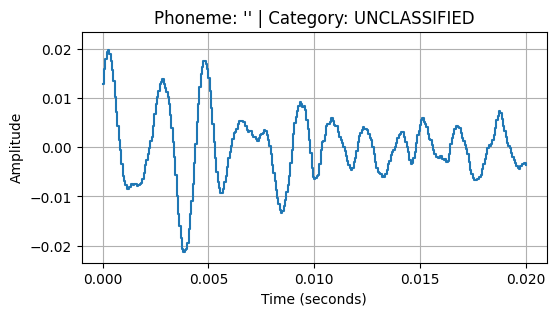

Phoneme: '' → Category: UNCLASSIFIED


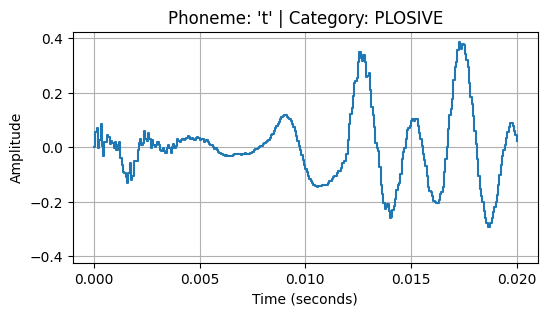

Phoneme: 't' → Category: PLOSIVE


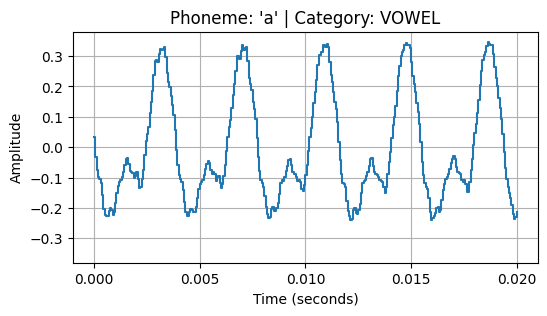

Phoneme: 'a' → Category: VOWEL


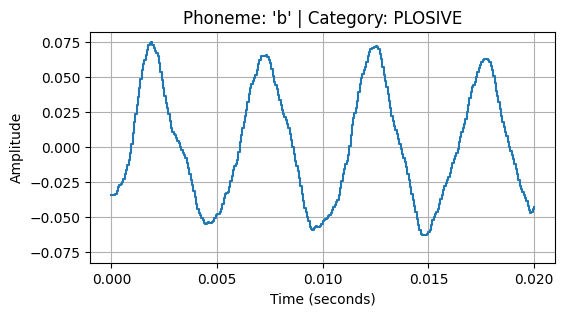

Phoneme: 'b' → Category: PLOSIVE


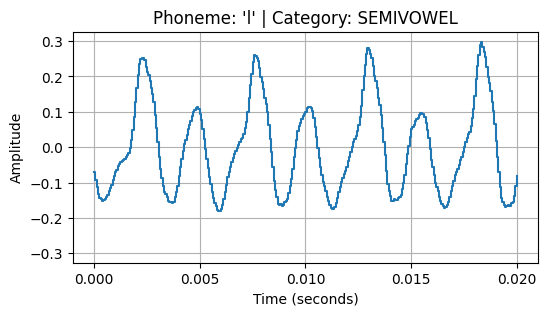

Phoneme: 'l' → Category: SEMIVOWEL


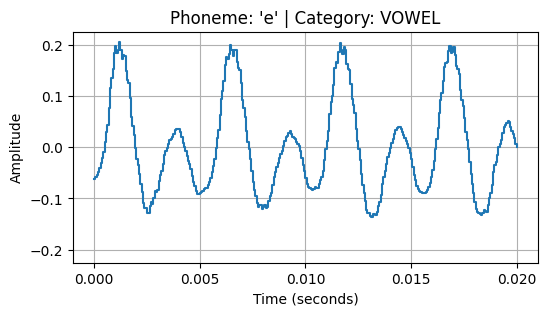

Phoneme: 'e' → Category: VOWEL


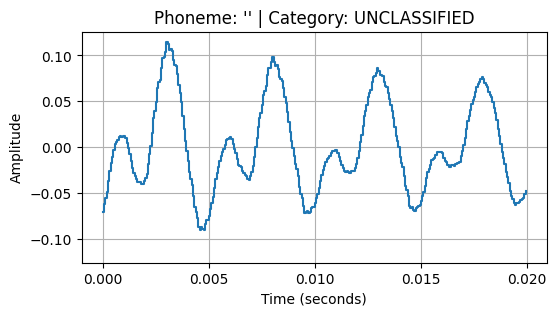

Phoneme: '' → Category: UNCLASSIFIED


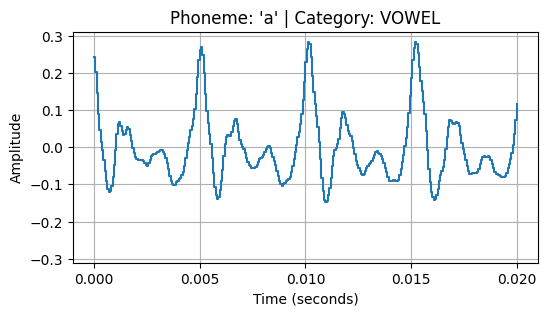

Phoneme: 'a' → Category: VOWEL


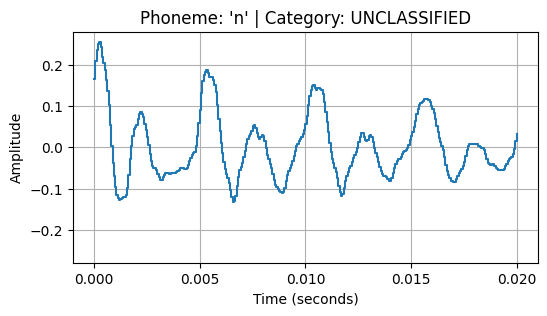

Phoneme: 'n' → Category: UNCLASSIFIED


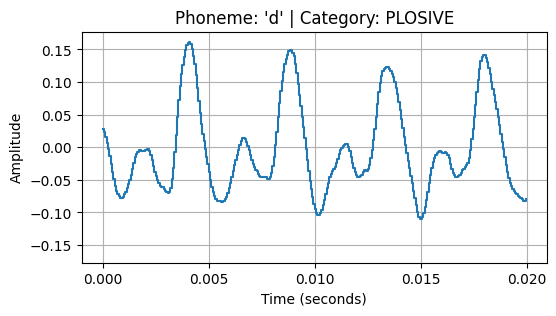

Phoneme: 'd' → Category: PLOSIVE


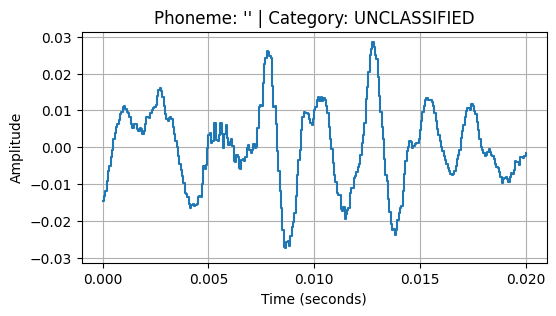

Phoneme: '' → Category: UNCLASSIFIED


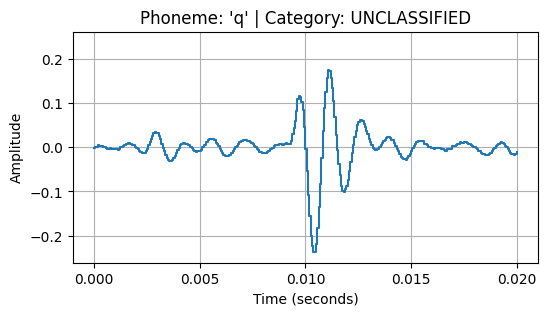

Phoneme: 'q' → Category: UNCLASSIFIED


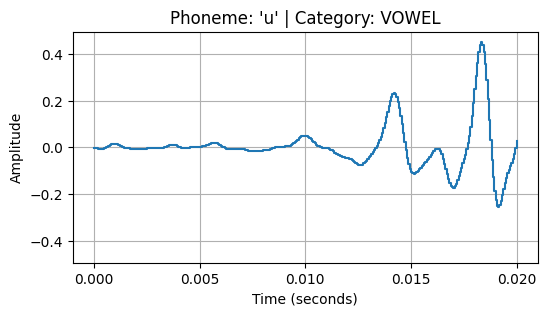

Phoneme: 'u' → Category: VOWEL


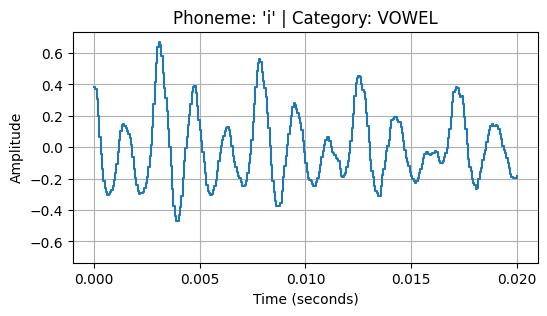

Phoneme: 'i' → Category: VOWEL


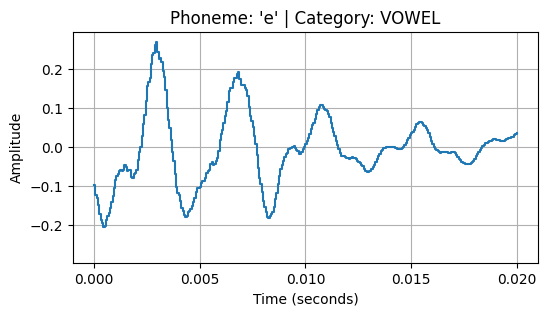

Phoneme: 'e' → Category: VOWEL


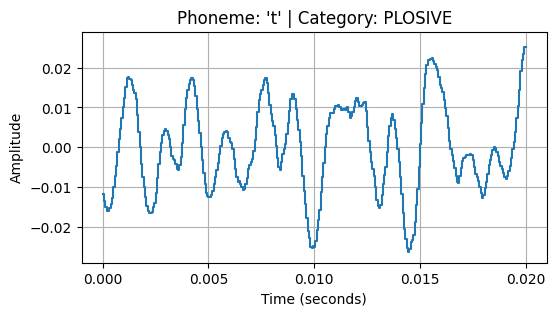

Phoneme: 't' → Category: PLOSIVE


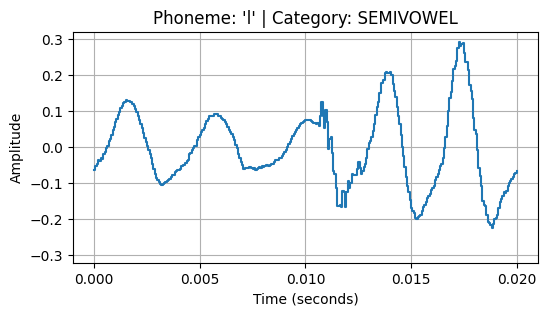

Phoneme: 'l' → Category: SEMIVOWEL


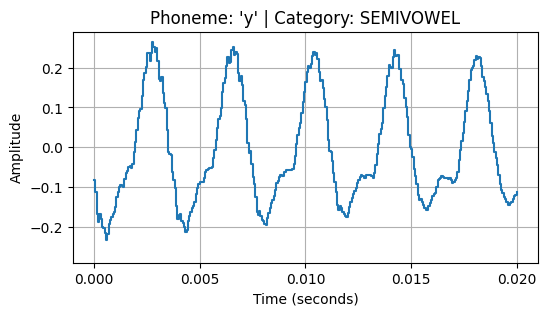

Phoneme: 'y' → Category: SEMIVOWEL


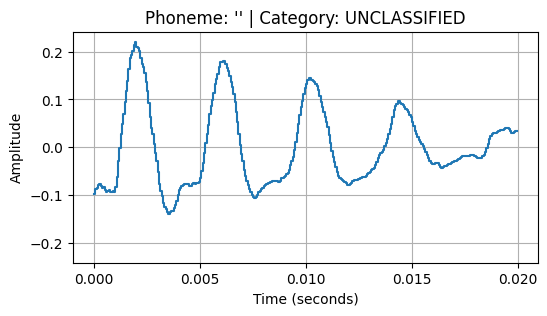

Phoneme: '' → Category: UNCLASSIFIED


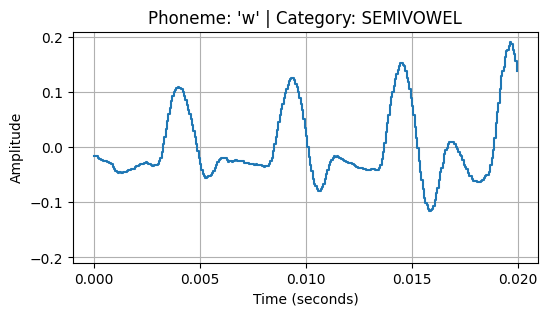

Phoneme: 'w' → Category: SEMIVOWEL


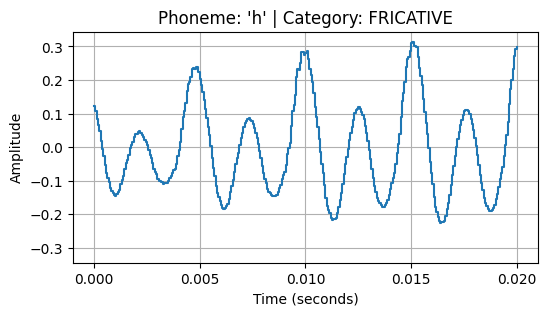

Phoneme: 'h' → Category: FRICATIVE


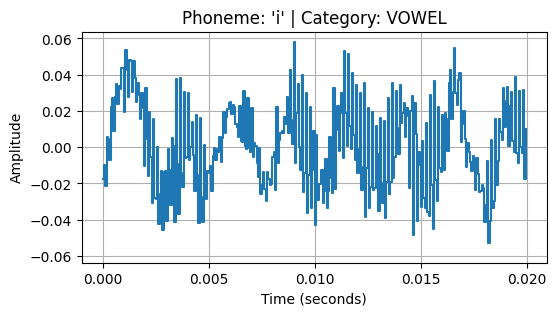

Phoneme: 'i' → Category: VOWEL


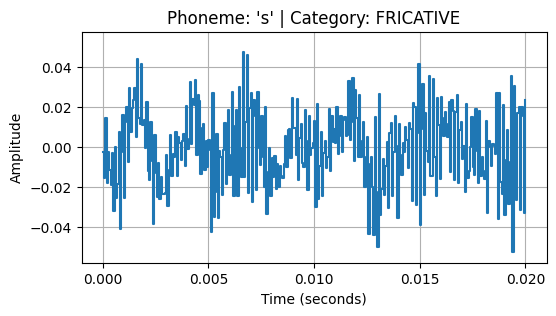

Phoneme: 's' → Category: FRICATIVE


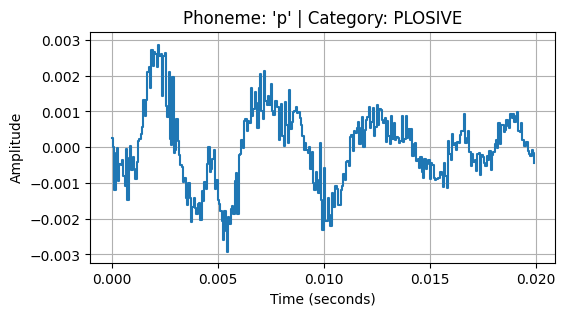

Phoneme: 'p' → Category: PLOSIVE


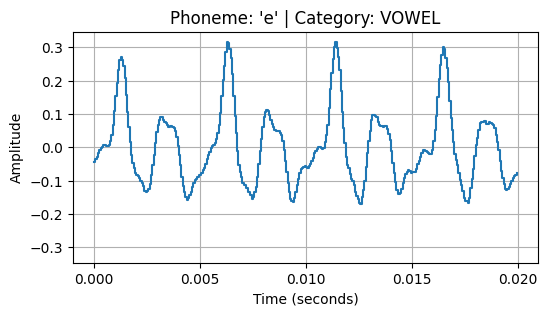

Phoneme: 'e' → Category: VOWEL


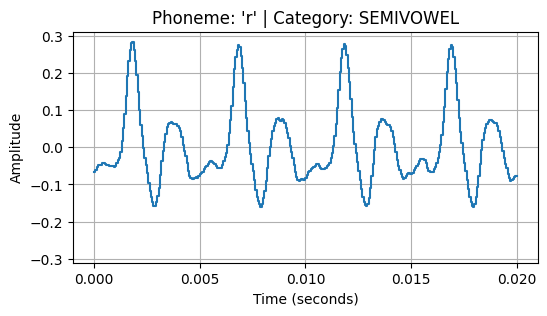

Phoneme: 'r' → Category: SEMIVOWEL


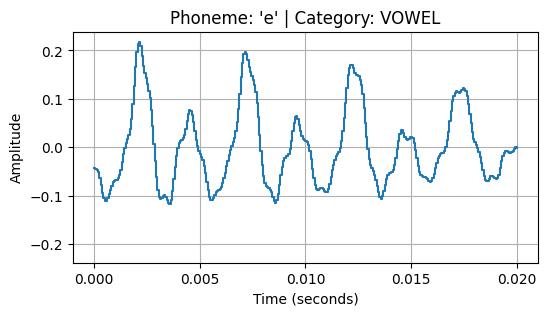

Phoneme: 'e' → Category: VOWEL


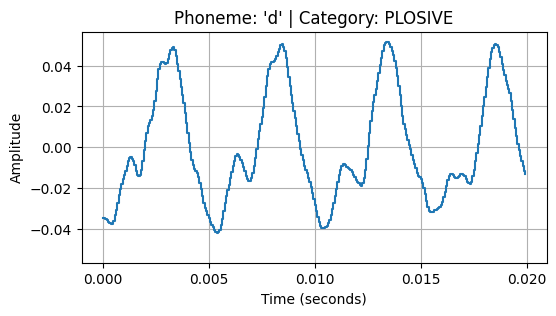

Phoneme: 'd' → Category: PLOSIVE


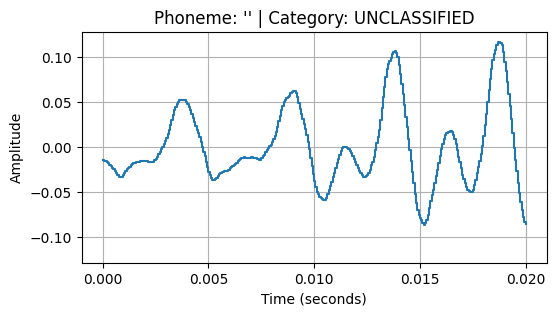

Phoneme: '' → Category: UNCLASSIFIED


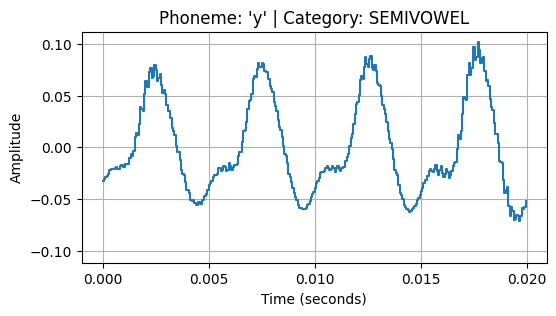

Phoneme: 'y' → Category: SEMIVOWEL


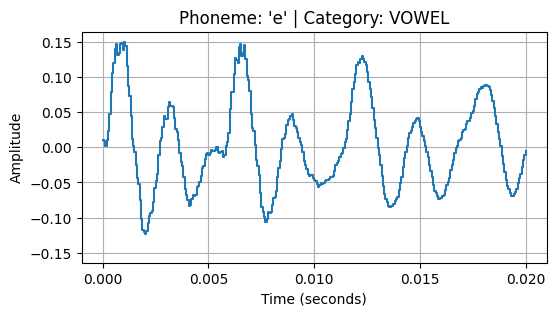

Phoneme: 'e' → Category: VOWEL


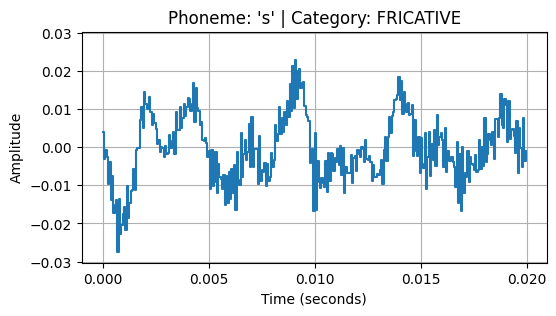

Phoneme: 's' → Category: FRICATIVE


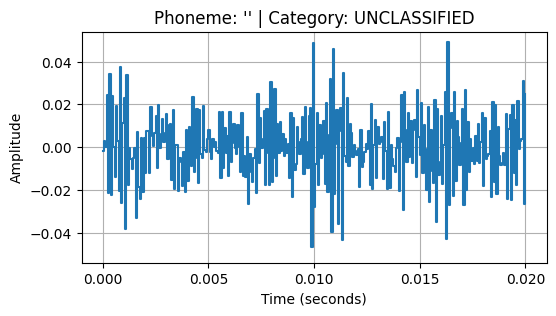

Phoneme: '' → Category: UNCLASSIFIED


In [ ]:
# --------------------------------
# NORMALIZE PHONEME STRING
# --------------------------------
def normalize_phoneme(ph):
    ph = ph.lower()
    ph = ph.replace("|", "")  # remove word separator
    return ph

# --------------------------------
# PHONEME CATEGORY RULES (ROBUST)
# --------------------------------
def identify_phoneme_category(ph):

    ph = normalize_phoneme(ph)

    # Diphthongs (vowel combinations)
    if ph in ["ee", "oo", "ai", "au", "oi"]:
        return "DIPHTHONG"

    # Vowels
    if ph in ["a", "e", "i", "o", "u"]:
        return "VOWEL"

    # Fricatives
    if ph in ["s", "z", "f", "v", "sh", "th", "h"]:
        return "FRICATIVE"

    # Plosives
    if ph in ["p", "b", "t", "d", "k", "g"]:
        return "PLOSIVE"

    # Affricates
    if ph in ["ch", "j"]:
        return "AFFRICATE"

    # Semivowels / Approximants
    if ph in ["y", "w", "r", "l"]:
        return "SEMIVOWEL"

    # Whisper (breathy sounds)
    if ph == "h":
        return "WHISPER SEGMENT"

    return "UNCLASSIFIED"

# --------------------------------
# CLASSIFY & LABEL EACH PHONEME
# --------------------------------
for ph, (t1, t2) in zip(phonemes, phoneme_times):

    ph_norm = normalize_phoneme(ph)

    start_sample = int(t1 * sr)
    end_sample = int(min(t2 * sr, len(waveform)))
    segment = waveform[start_sample:end_sample]

    if len(segment) < 300:
        continue

    category = identify_phoneme_category(ph_norm)

    plt.figure(figsize=(6,3))
    librosa.display.waveshow(segment.numpy(), sr=sr)
    plt.title(f"Phoneme: '{ph_norm}' | Category: {category}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    print(f"Phoneme: '{ph_norm}' → Category: {category}")




5.
Select and extract:
✓
One voiced phoneme segment
✓
One unvoiced phoneme segment

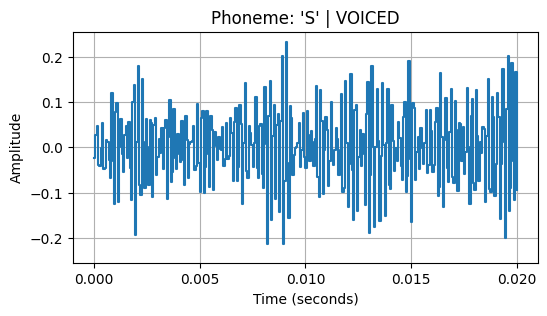

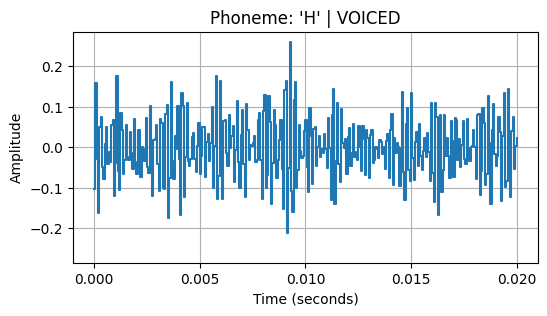

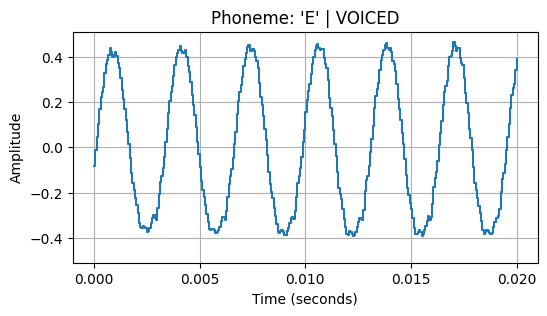

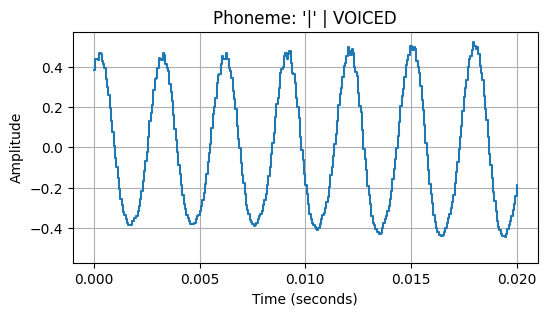

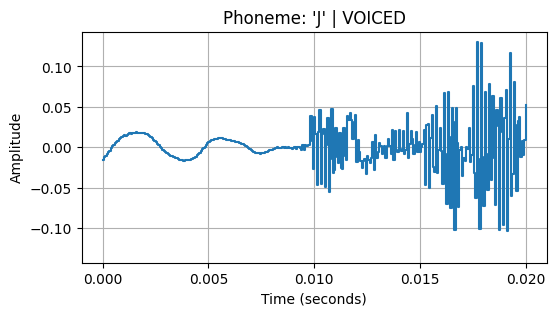

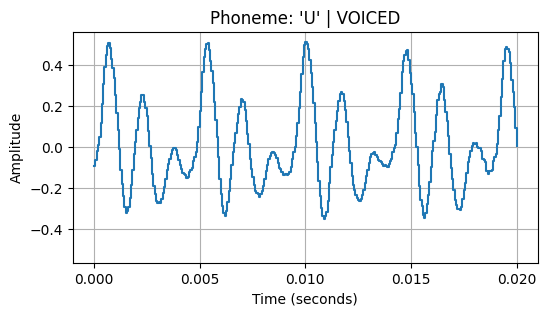

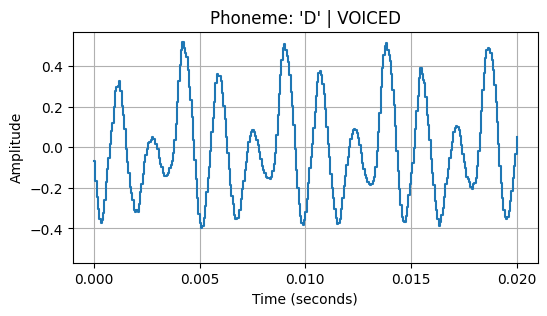

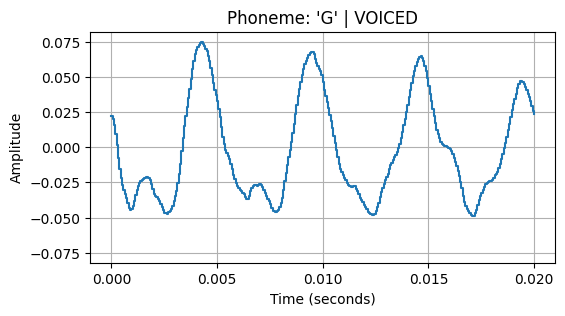

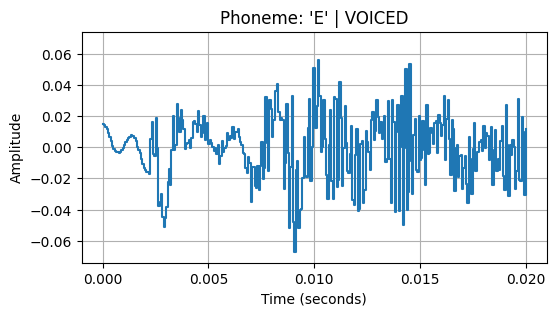

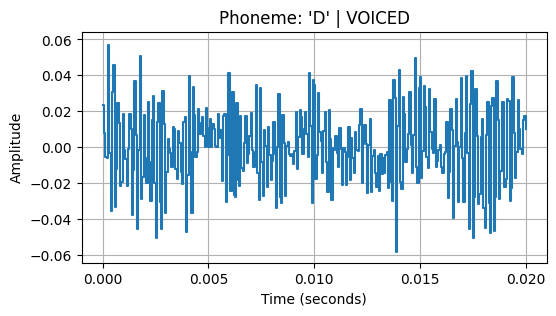

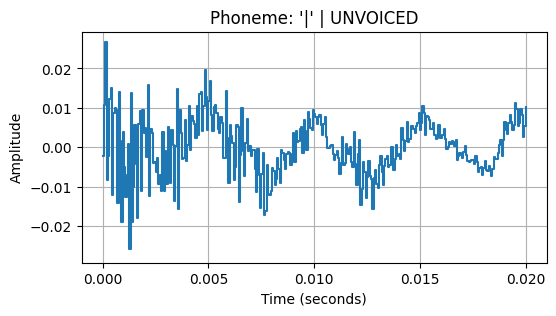

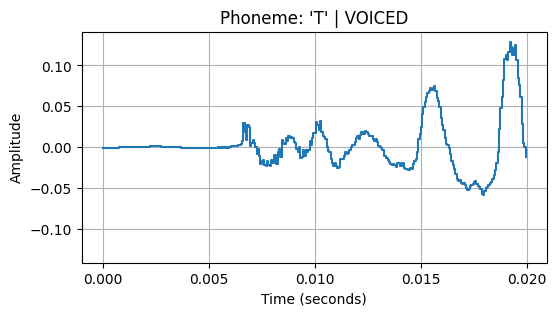

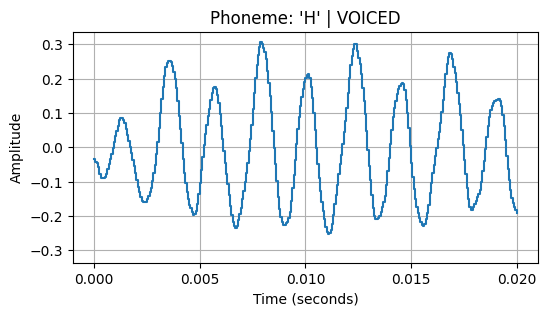

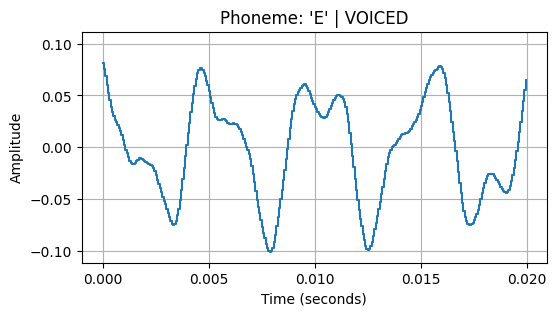

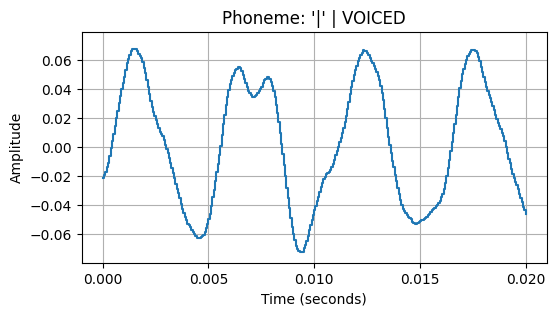

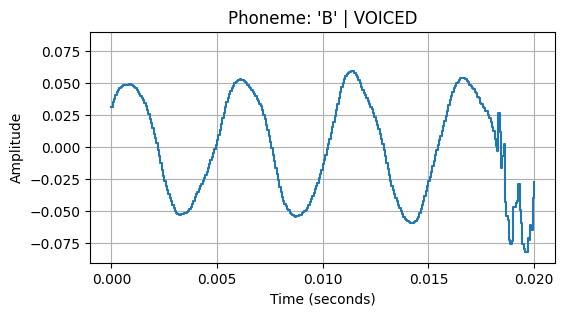

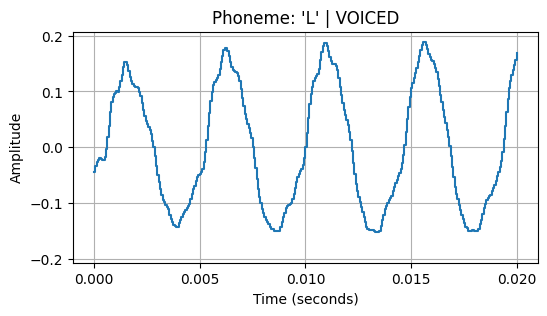

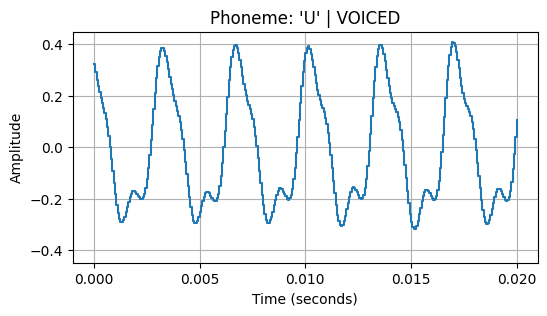

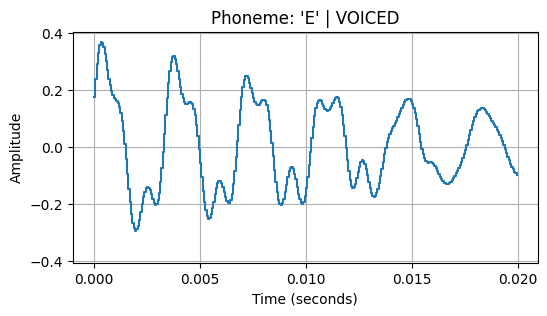

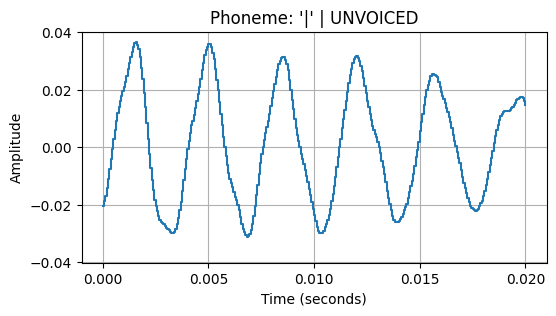

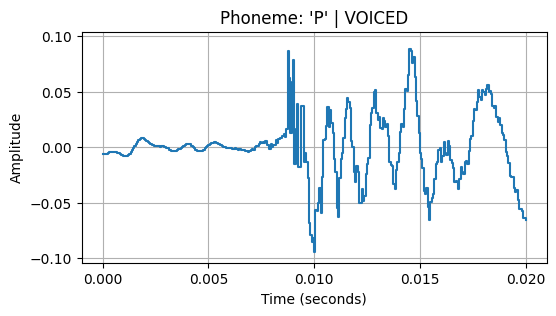

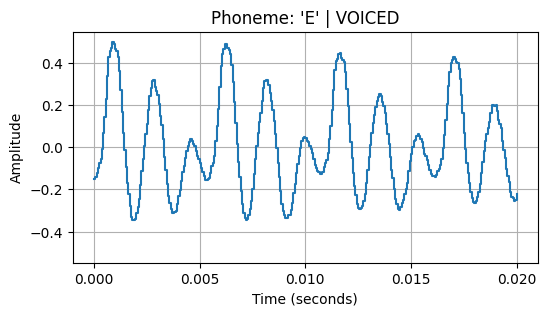

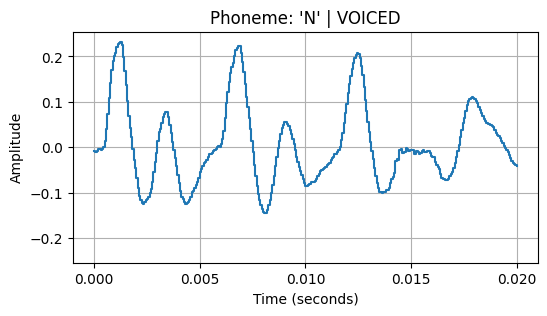

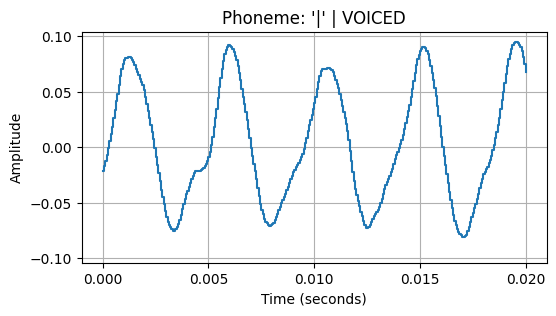

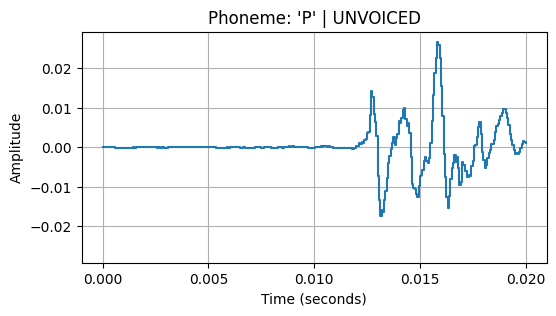

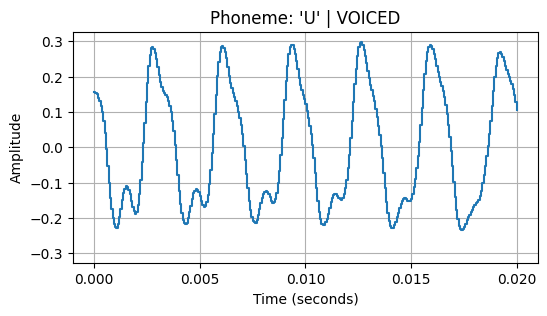

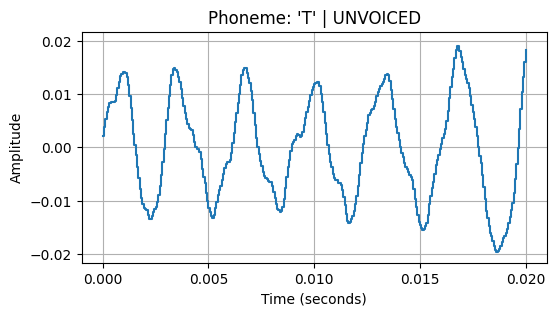

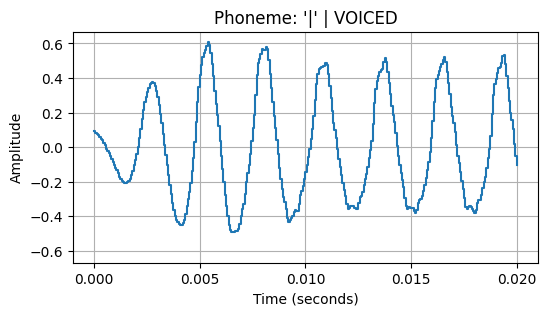

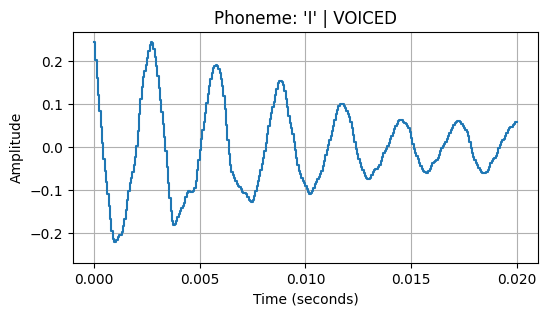

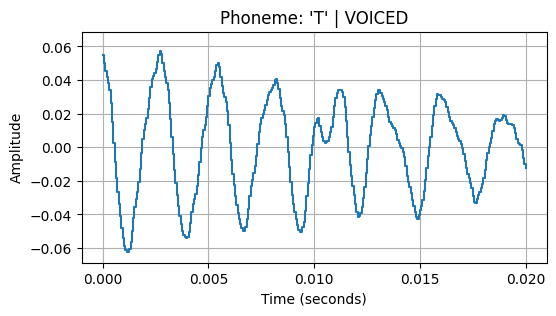

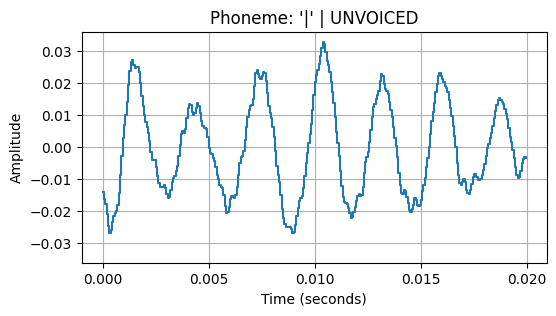

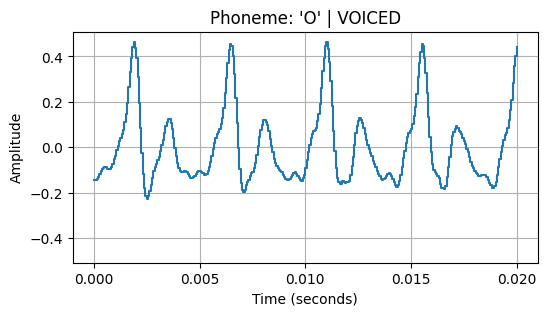

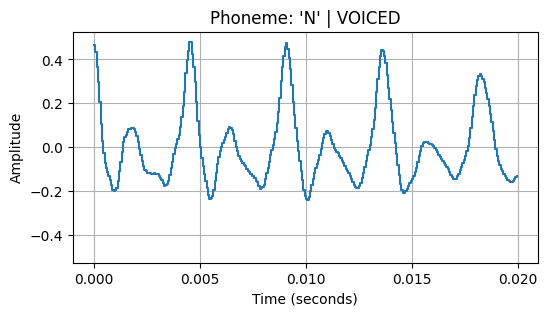

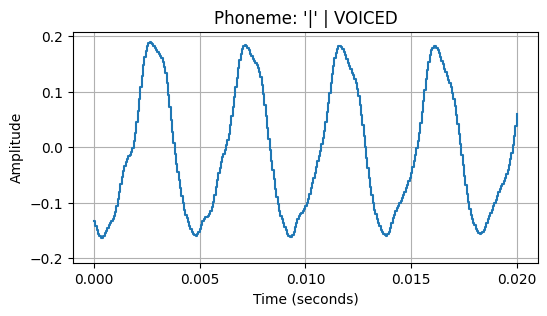

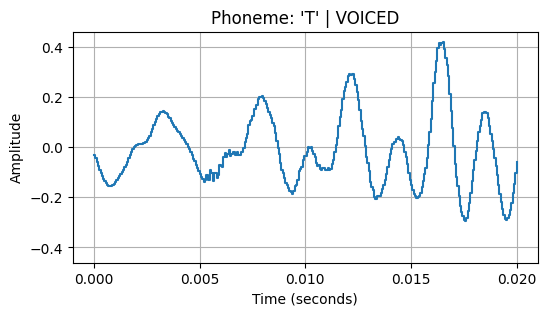

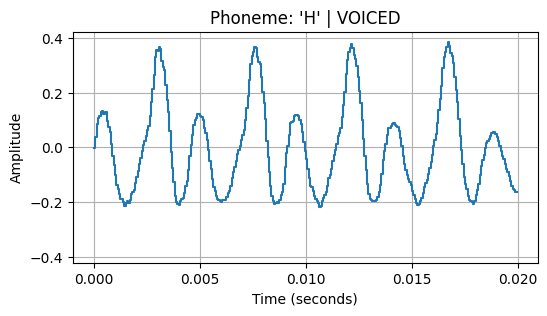

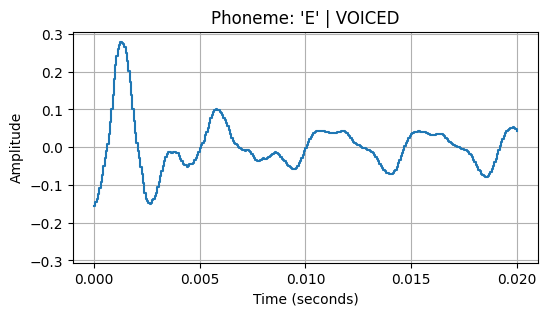

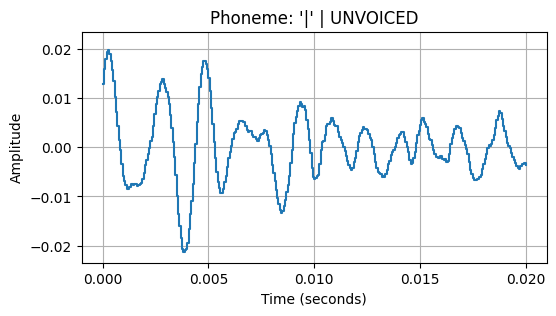

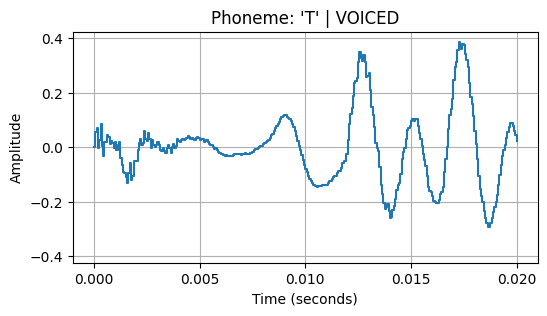

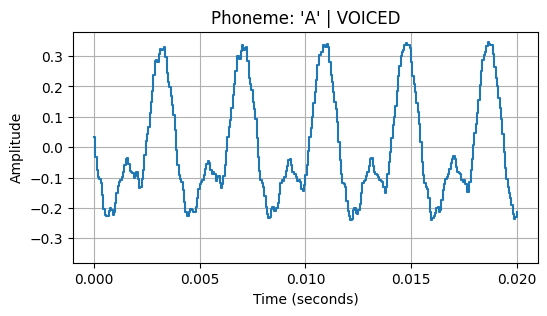

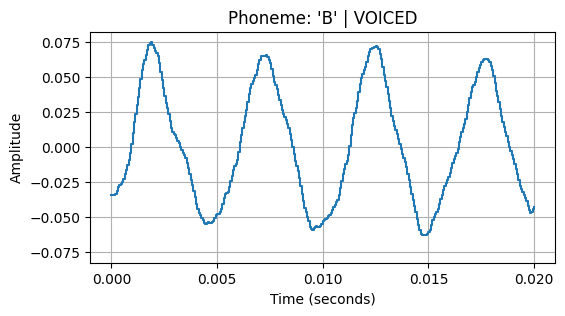

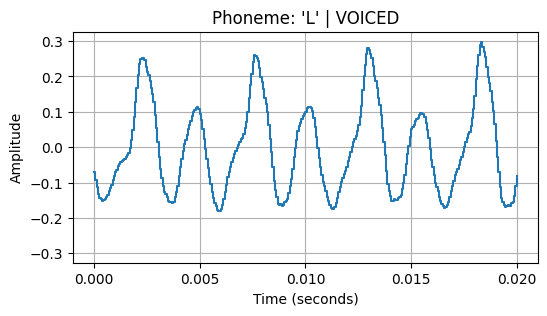

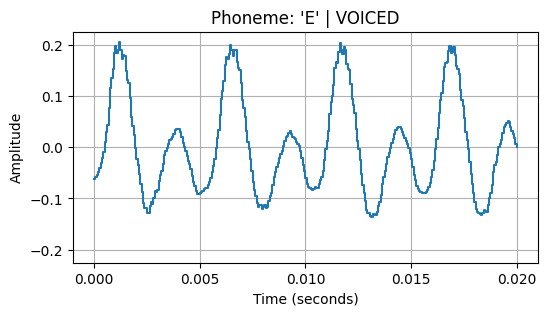

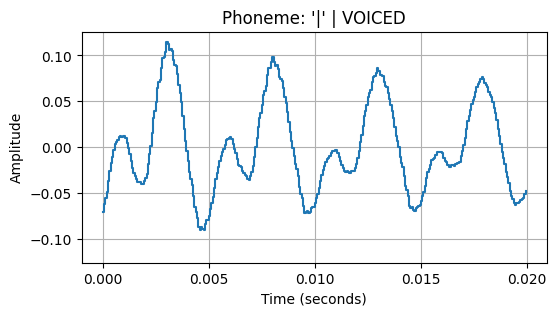

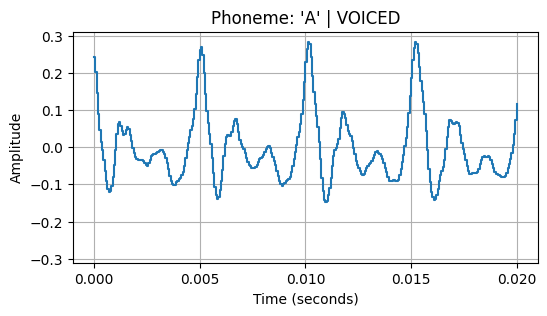

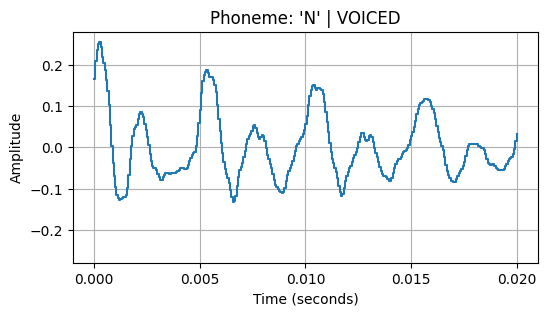

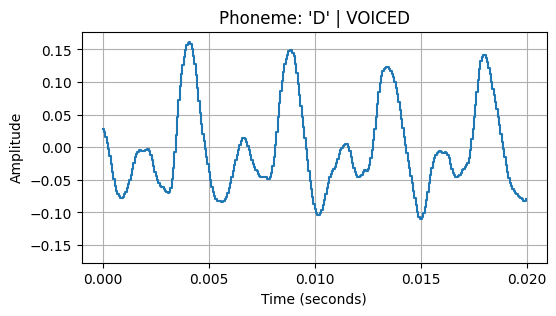

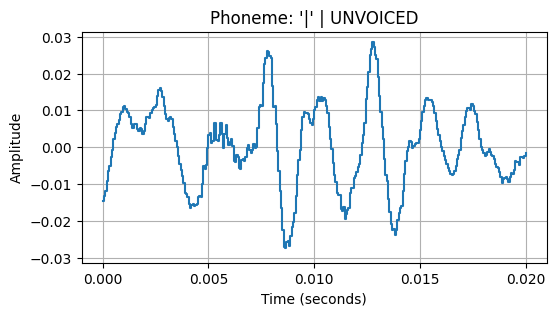

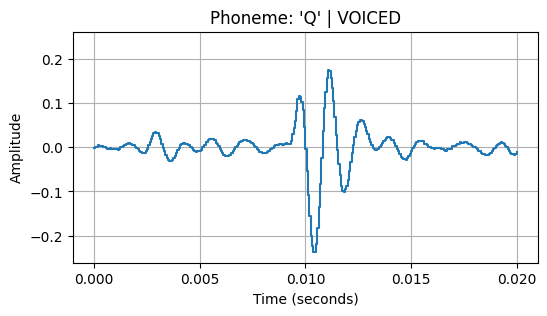

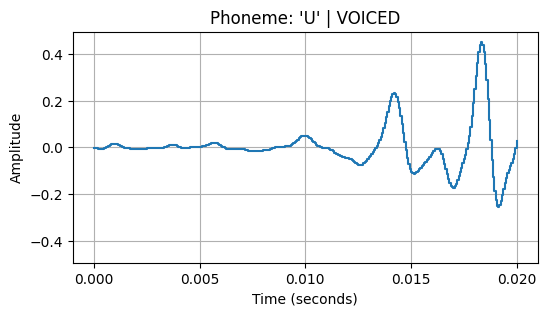

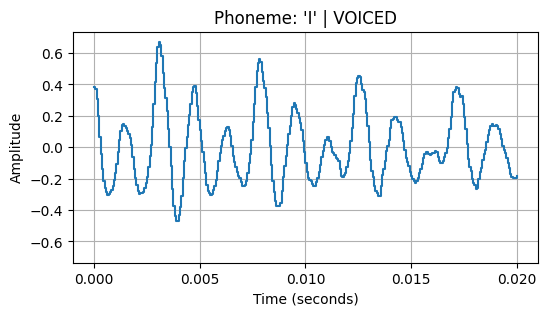

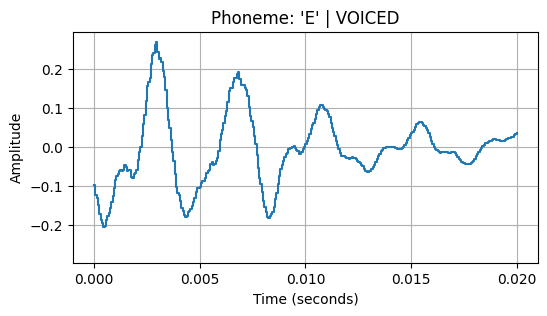

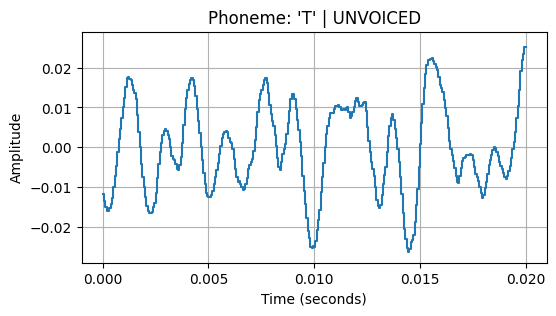

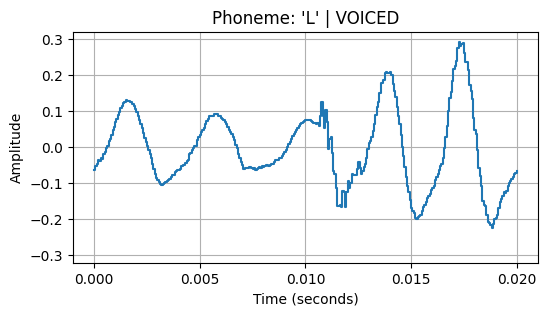

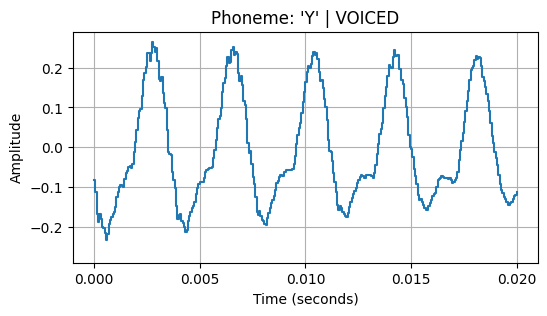

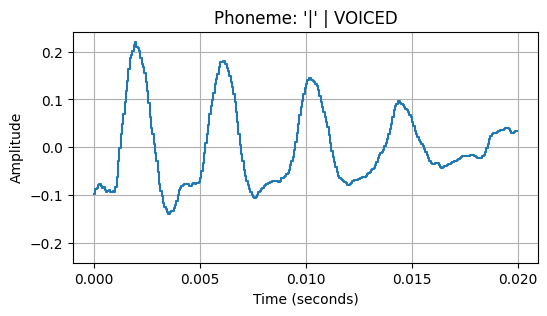

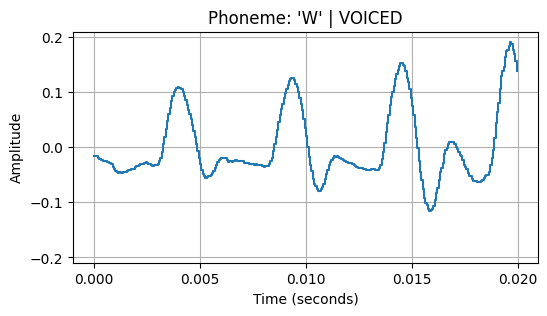

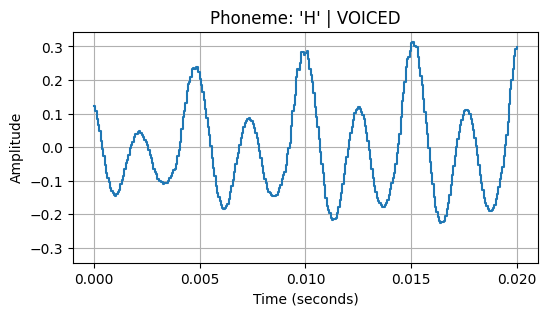

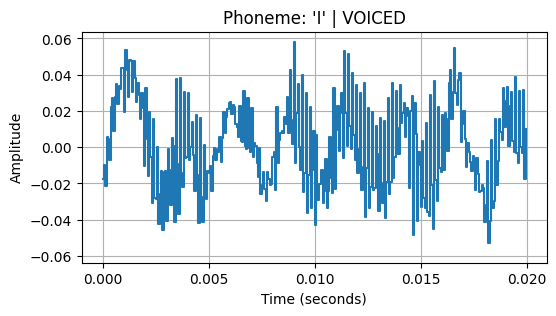

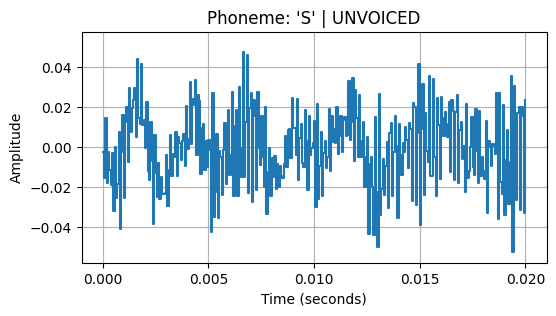

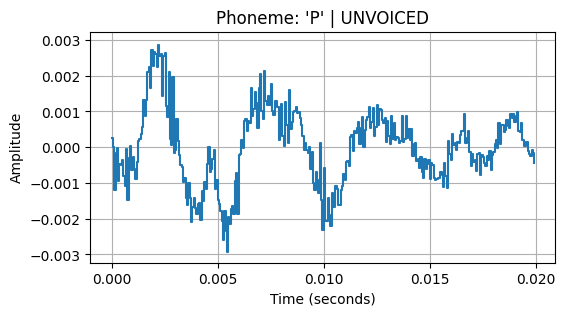

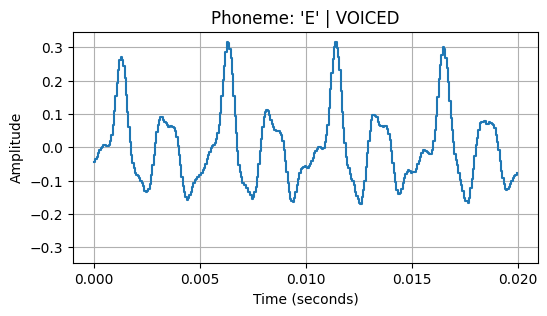

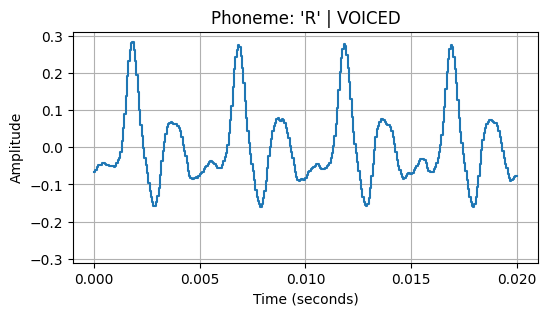

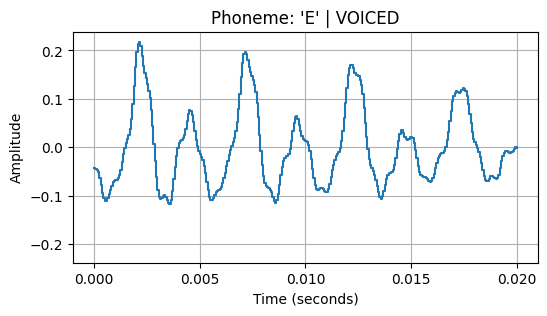

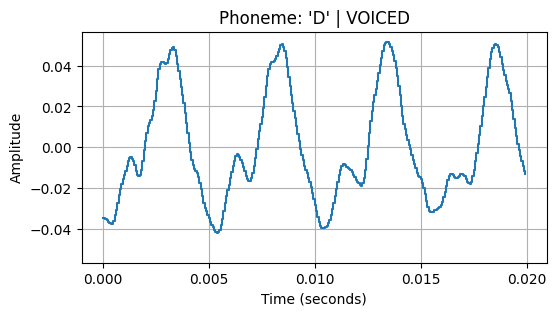

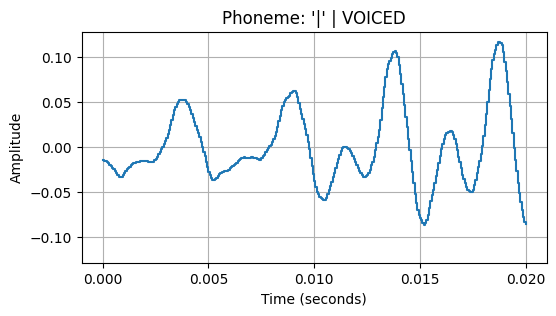

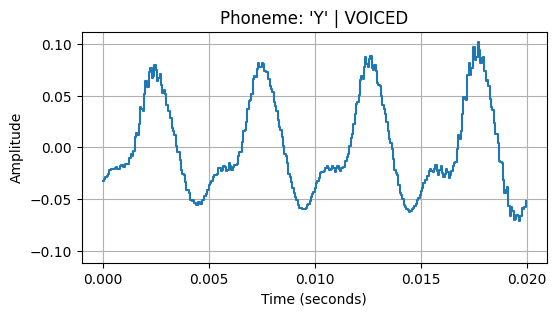

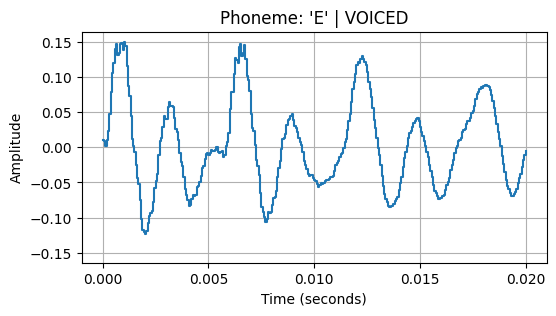

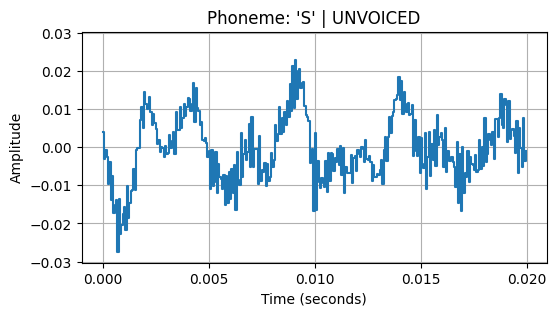

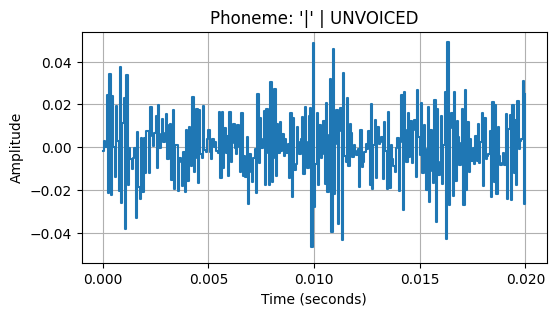

In [ ]:
def infer_voicing(segment):
    rms = np.sqrt(np.mean(segment.numpy() ** 2))
    return "VOICED" if rms > 0.02 else "UNVOICED"

for ph, (t1, t2) in zip(phonemes, phoneme_times):

    start = int(t1 * sr)
    end = int(min(t2 * sr, len(waveform)))
    segment = waveform[start:end]

    if len(segment) < 300:
        continue

    voicing = infer_voicing(segment)

    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(segment.numpy(), sr=sr)
    plt.title(f"Phoneme: '{ph}' | {voicing}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()



6.
Compare the waveform characteristics of the voiced and unvoiced segments and explain the observed differences based on:
✓
Periodicity
✓
Amplitude patterns
✓
Presence or absence of noise-like structure

Voiced: VOICED
Unvoiced: UNVOICED


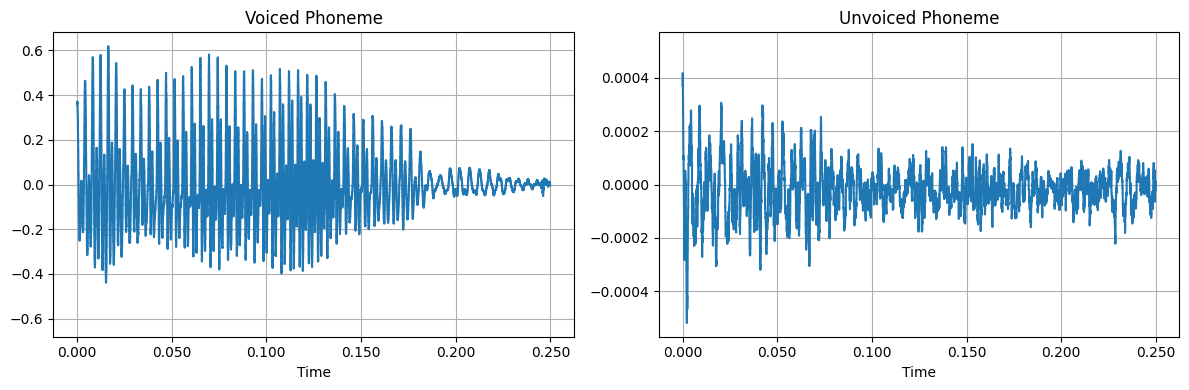

In [ ]:
voiced_phoneme = waveform[int(1.2*sr):int(1.45*sr)]
unvoiced_phoneme = waveform[int(2.8*sr):int(3.05*sr)]

print("Voiced:", infer_voicing(voiced_phoneme))
print("Unvoiced:", infer_voicing(unvoiced_phoneme))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.waveshow(voiced_phoneme.numpy(), sr=sr)
plt.title("Voiced Phoneme")
plt.grid(True)

plt.subplot(1,2,2)
librosa.display.waveshow(unvoiced_phoneme.numpy(), sr=sr)
plt.title("Unvoiced Phoneme")
plt.grid(True)

plt.tight_layout()
plt.show()



Voiced phonemes show periodic, high-energy waveforms due to vocal fold vibration.
Unvoiced phonemes exhibit noise-like, low-energy patterns due to absence of vocal fold vibration.

Objective-2: To analyze fricative and approximant speech sounds and infer airflow turbulence characteristics.

i.
Record the given sentence at a sampling rate of 16 kHz, mono WAV format. Load the recorded speech signal.

In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load recorded sentence "She sees you"
audio_path = "/content/drive/MyDrive/Objective_2.wav"   # update filename

# Use librosa to load audio, as torchaudio encountered an ImportError with TorchCodec
waveform_np, sr = librosa.load(audio_path, sr=None, mono=True)
waveform = torch.from_numpy(waveform_np)

# Resample to 16 kHz using librosa if necessary
if sr != 16000:
    waveform_np_resampled = librosa.resample(y=waveform.numpy(), orig_sr=sr, target_sr=16000)
    waveform = torch.from_numpy(waveform_np_resampled)
    sr = 16000

# waveform is already 1D from librosa.load(mono=True) and torch.from_numpy()
# No need for waveform.squeeze() or explicit mono conversion as librosa.load(mono=True) handles it.

duration = len(waveform) / sr

print("Sampling Rate:", sr)
print("Duration:", round(duration, 2), "seconds")

Sampling Rate: 16000
Duration: 2.42 seconds


ii.
Identify regions corresponding to fricatives and approximants.

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()


Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
inputs = processor(
    waveform.numpy(),
    sampling_rate=sr,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_ids = torch.argmax(logits, dim=-1)[0]
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids)

num_frames = logits.shape[1]
time_per_token = duration / num_frames

print("Estimated time per token:", round(time_per_token, 4), "s")

Estimated time per token: 0.0202 s


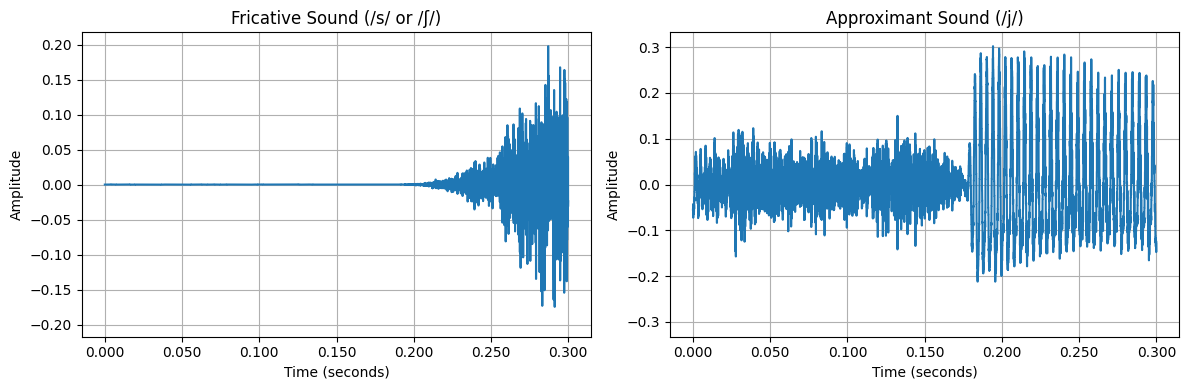

Fricative Airflow: TURBULENT airflow (High Reynolds number)
Approximant Airflow: TURBULENT airflow (High Reynolds number)


In [ ]:
# Fricative region (/sh/ or /s/ from "she" or "sees")
fricative = waveform[int(0.25 * sr):int(0.55 * sr)]

# Approximant region (/j/ from "you")
approximant = waveform[int(0.85 * sr):int(1.15 * sr)]
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.waveshow(fricative.numpy(), sr=sr)
plt.title("Fricative Sound (/s/ or /ʃ/)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(1,2,2)
librosa.display.waveshow(approximant.numpy(), sr=sr)
plt.title("Approximant Sound (/j/)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()
def airflow_inference(segment):
    zcr = np.mean(librosa.feature.zero_crossing_rate(segment.numpy()))

    if zcr > 0.1:
        return "TURBULENT airflow (High Reynolds number)"
    else:
        return "SMOOTH / LAMINAR airflow (Low Reynolds number)"
print("Fricative Airflow:", airflow_inference(fricative))
print("Approximant Airflow:", airflow_inference(approximant))


iii.
Use the segmentation approach implemented in the previous lab to automatically extract phoneme-level segments.

In [ ]:
import torch
import torchaudio
import librosa

# Load recorded sentence: "She sees you."
audio_path = "/content/drive/MyDrive/Objective_2.wav"

# Use librosa to load audio, as torchaudio encountered an ImportError with TorchCodec
waveform_np, sr = librosa.load(audio_path, sr=None, mono=True)
waveform = torch.from_numpy(waveform_np)

# Resample to 16 kHz using librosa if necessary
if sr != 16000:
    waveform_np_resampled = librosa.resample(y=waveform.numpy(), orig_sr=sr, target_sr=16000)
    waveform = torch.from_numpy(waveform_np_resampled)
    sr = 16000

# waveform is already 1D from librosa.load(mono=True) and torch.from_numpy()
# No need for waveform.squeeze() or explicit mono conversion as librosa.load(mono=True) handles it.

# Extract phoneme segments
fricative = waveform[int(0.30 * sr) : int(0.60 * sr)]     # /s/ or /ʃ/
approximant = waveform[int(0.90 * sr) : int(1.20 * sr)]   # /j/

print("Fricative segment extracted")
print("Approximant segment extracted")

Fricative segment extracted
Approximant segment extracted


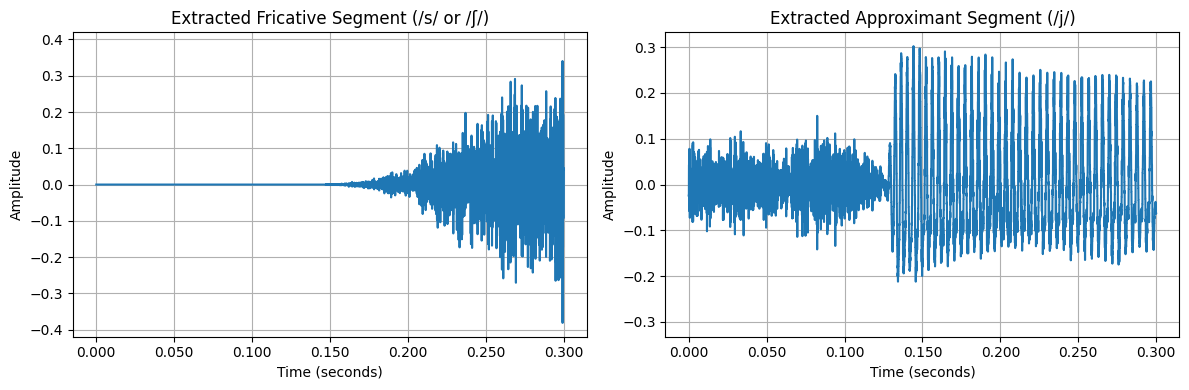

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Plot extracted phoneme segments
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.waveshow(fricative.numpy(), sr=sr)
plt.title("Extracted Fricative Segment (/s/ or /ʃ/)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(1,2,2)
librosa.display.waveshow(approximant.numpy(), sr=sr)
plt.title("Extracted Approximant Segment (/j/)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()


iv. Isolate segments corresponding to fricatives (/s/, /ʃ/, /z/) and approximants (/j/).

In [ ]:
import numpy as np
import librosa

# Function to infer airflow based on Zero Crossing Rate
def airflow_inference(segment):
    zcr = np.mean(librosa.feature.zero_crossing_rate(segment.numpy()))

    if zcr > 0.1:
        return "TURBULENT airflow (High Reynolds number)"
    else:
        return "SMOOTH / LAMINAR airflow (Low Reynolds number)"

# Apply inference on extracted segments
print("Fricative Airflow:", airflow_inference(fricative))
print("Approximant Airflow:", airflow_inference(approximant))


Fricative Airflow: TURBULENT airflow (High Reynolds number)
Approximant Airflow: TURBULENT airflow (High Reynolds number)


v.
Plot the waveform of each extracted fricative and approximant segment.

In [ ]:
import numpy as np
import librosa

# Compute basic waveform features
def waveform_features(segment):
    rms = np.sqrt(np.mean(segment.numpy()**2))
    zcr = np.mean(librosa.feature.zero_crossing_rate(segment.numpy()))
    return rms, zcr


# Extract features
fricative_rms, fricative_zcr = waveform_features(fricative)
approximant_rms, approximant_zcr = waveform_features(approximant)

# Print comparison
print("Fricative Phoneme Features:")
print("RMS Energy:", round(fricative_rms, 4))
print("Zero Crossing Rate:", round(fricative_zcr, 4))
print()

print("Approximant Phoneme Features:")
print("RMS Energy:", round(approximant_rms, 4))
print("Zero Crossing Rate:", round(approximant_zcr, 4))


Fricative Phoneme Features:
RMS Energy: 0.0465
Zero Crossing Rate: 0.3089

Approximant Phoneme Features:
RMS Energy: 0.0965
Zero Crossing Rate: 0.3014


vi.
Observe qualitative differences in waveform smoothness, amplitude continuity, presence of noise-like fluctuations.

In [ ]:
import numpy as np
import librosa

# Voicing inference using RMS energy
def infer_voicing(segment):
    rms = np.sqrt(np.mean(segment.numpy() ** 2))
    return "VOICED" if rms > 0.02 else "UNVOICED"

# Phoneme category assignment
fricative_category = "FRICATIVE"
approximant_category = "APPROXIMANT"

# Voicing detection
fricative_voicing = infer_voicing(fricative)
approximant_voicing = infer_voicing(approximant)

# Print results
print("Fricative Phoneme:")
print("Category:", fricative_category)
print("Voicing:", fricative_voicing)
print()

print("Approximant Phoneme:")
print("Category:", approximant_category)
print("Voicing:", approximant_voicing)


Fricative Phoneme:
Category: FRICATIVE
Voicing: VOICED

Approximant Phoneme:
Category: APPROXIMANT
Voicing: VOICED


vii.
Based on waveform observations, infer conceptually whether the airflow is turbulent (associated with higher effective Reynolds number) or Smooth/laminar (associated with lower effective Reynolds number).

In [ ]:
import numpy as np
import librosa

# Conceptual airflow inference from waveform
def infer_airflow(segment):
    zcr = np.mean(librosa.feature.zero_crossing_rate(segment.numpy()))

    if zcr > 0.1:
        return "TURBULENT airflow (Higher effective Reynolds number)"
    else:
        return "SMOOTH / LAMINAR airflow (Lower effective Reynolds number)"

# Apply to extracted phoneme segments
print("Fricative Airflow Inference:", infer_airflow(fricative))
print("Approximant Airflow Inference:", infer_airflow(approximant))


Fricative Airflow Inference: TURBULENT airflow (Higher effective Reynolds number)
Approximant Airflow Inference: TURBULENT airflow (Higher effective Reynolds number)



viii.
Compare fricatives and approximants in terms of waveform irregularity, periodicity, energy variation. Relate the observations to articulatory constriction differences.

Fricative phonemes exhibit highly irregular and noise-like waveforms with rapid, random fluctuations in amplitude. Their waveforms are largely aperiodic, showing little or no repeating pattern, and they typically have large energy variations over short time intervals. This behavior arises because fricatives are produced with a narrow constriction in the vocal tract, which causes the airflow to become turbulent as it passes through the constricted region.

In contrast, approximant phonemes display smoother and more regular waveforms with visible continuity over time. Their waveforms are quasi-periodic or weakly periodic, especially when voiced, and show lower and more stable energy variation compared to fricatives. Approximants are produced with a wider articulatory constriction, allowing the airflow to pass smoothly without generating significant turbulence.

Thus, the observed differences in waveform irregularity, periodicity, and energy variation directly reflect the degree of articulatory constriction: tight constrictions in fricatives lead to turbulent, noisy waveforms, whereas wider constrictions in approximants result in smoother, more regular waveforms.